"""
=================================================================================
AIR POLLUTION MULTIMODAL MODEL - COMPLETE KAGGLE NOTEBOOK
=================================================================================
Vision Transformer + Attention MLP + Gated Multimodal Fusion

Dataset: https://www.kaggle.com/datasets/adarshrouniyar/air-pollution-image-dataset-from-india-and-nepal

Architecture:
1. Vision Transformer (ViT-Base) for images
2. Attention MLP for tabular meteorological data  
3. Gated Multimodal Fusion
4. Classification Head

Table 2 Implementation:
- Resize: 224×224
- Normalize: ImageNet mean/std
- Augmentations: Haze, fog, blur, brightness (NOVELTY #1)
=================================================================================
"""

# SECTION 1: INSTALLATION AND IMPORTS

In [1]:
# Install required packages
!pip install -q albumentations transformers accelerate

import os
import numpy as np
import pandas as pd
import torch
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla P100-PCIE-16GB


# SECTION 2: CONFIGURATION

In [2]:
import sys
!{sys.executable} -m pip install -q albumentations transformers accelerate

# Core imports
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

# Image processing
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Model
from transformers import ViTModel, ViTConfig

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import json
import random
import warnings
warnings.filterwarnings('ignore')

print("✓ All packages imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

2026-02-04 16:06:57.156673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770221217.331226      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770221217.387633      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770221217.805142      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770221217.805183      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770221217.805186      55 computation_placer.cc:177] computation placer alr

✓ All packages imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla P100-PCIE-16GB


In [3]:
class Config:
    """Central configuration class"""
    
    # ============ UPDATE THESE PATHS ============
    IMAGE_DIR = '/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img/'
    CSV_PATH = '/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_Nep_AQI_Dataset.csv'
    # ============================================
    
    # Image preprocessing
    IMG_SIZE = 224
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]
    
    # Data splitting
    BATCH_SIZE = 32
    TEST_SIZE = 0.2
    VAL_SIZE = 0.1
    RANDOM_SEED = 42
    
    # Model architecture
    VIT_MODEL = 'google/vit-base-patch16-224'
    TABULAR_HIDDEN_DIMS = [256, 128]
    FUSION_DIM = 256
    DROPOUT = 0.3
    
    # Training
    NUM_EPOCHS = 5
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-4
    WARMUP_EPOCHS = 5
    UNFREEZE_EPOCH = 10
    
    # Learning rate scheduling
    SCHEDULER_TYPE = 'cosine'
    T_MAX = 50
    
    # Early stopping
    PATIENCE = 15
    MIN_DELTA = 0.001
    
    # Output
    SAVE_DIR = '/kaggle/working/checkpoints'
    
    # Device
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    USE_AMP = True  # Mixed precision training

print("✓ Configuration loaded")
print(f"Device: {Config.DEVICE}")

✓ Configuration loaded
Device: cuda


# SECTION 3: DATA PREPROCESSING

In [4]:
# Set random seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(Config.RANDOM_SEED)
print(f"✓ Random seed set to {Config.RANDOM_SEED}")

# Create output directory
os.makedirs(Config.SAVE_DIR, exist_ok=True)
print(f"✓ Output directory: {Config.SAVE_DIR}")

# =============================================================================
# SECTION 3: DATA PREPROCESSING
# =============================================================================

print("\n" + "="*80)
print("SECTION 3: DATA PREPROCESSING")
print("="*80)

# -----------------------------------------------------------------------------
# 3.1: Image Augmentation Functions (Table 2 Implementation)
# -----------------------------------------------------------------------------

def get_train_transforms():
    """
    Training augmentations implementing Table 2
    - Resize to 224×224
    - ImageNet normalization
    - NOVELTY #1: Atmospheric augmentations (haze, fog, blur)
    """
    return A.Compose([
        # Resize to standard input size
        A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
        
        # ===== NOVELTY #1: Atmospheric Augmentations =====
        # Simulates real-world atmospheric conditions
        A.OneOf([
            A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.5, alpha_coef=0.1, p=0.3),  # Fog
            # FIX: RandomBrightness -> RandomBrightnessContrast
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.3),  
            A.GaussianBlur(blur_limit=(3, 7), p=0.3),  # Haze/blur
        ], p=0.5),
        
        # Standard augmentations
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.3),
        
        # This is already correct in your original code
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
        
        # Additional atmospheric effects
        A.OneOf([
            A.MotionBlur(blur_limit=5, p=0.2),
            A.MedianBlur(blur_limit=5, p=0.2),
        ], p=0.3),
        
        # Normalize with ImageNet statistics
        A.Normalize(
            mean=Config.IMAGENET_MEAN,
            std=Config.IMAGENET_STD,
            max_pixel_value=255.0
        ),
        
        # Convert to PyTorch tensor
        ToTensorV2()
    ])

def get_val_transforms():
    """Validation/Test transforms without augmentations"""
    return A.Compose([
        A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
        A.Normalize(
            mean=Config.IMAGENET_MEAN,
            std=Config.IMAGENET_STD,
            max_pixel_value=255.0
        ),
        ToTensorV2()
    ])

print("✓ Augmentation functions defined")

✓ Random seed set to 42
✓ Output directory: /kaggle/working/checkpoints

SECTION 3: DATA PREPROCESSING
✓ Augmentation functions defined


In [5]:
class TabularPreprocessor:
    """
    Preprocessor for tabular meteorological data
    Creates cyclical features for temporal data
    """
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_names = None
    
    def extract_hour_features(self, df):
        """Extract hour and create cyclical features for temporal data"""
        df = df.copy()
        
        # Extract hour as integer if it's a string
        if df['Hour'].dtype == 'object':
            df['Hour'] = df['Hour'].str.split(':').str[0].astype(int)
        
        # Create cyclical features (sine/cosine encoding)
        # Hour (24-hour cycle)
        df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
        df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
        
        # Month (12-month cycle)
        df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
        df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
        
        # Day (31-day cycle)
        df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
        df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
        
        return df
    
    def fit_transform(self, df):
        """Fit and transform tabular data"""
        df = df.copy()
        df = self.extract_hour_features(df)
        
        # Define features
        base_features = ['Year', 'AQI', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']
        cyclical_features = ['Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos']
        self.feature_names = base_features + cyclical_features
        
        # Handle missing values
        df[self.feature_names] = df[self.feature_names].fillna(df[self.feature_names].median())
        
        # Fit and transform
        scaled_data = self.scaler.fit_transform(df[self.feature_names])
        
        # Encode labels
        labels = self.label_encoder.fit_transform(df['AQI_Class'])
        
        return scaled_data, labels, df
    
    def transform(self, df):
        """Transform new data using fitted scaler"""
        df = df.copy()
        df = self.extract_hour_features(df)
        
        # Handle missing values
        df[self.feature_names] = df[self.feature_names].fillna(df[self.feature_names].median())
        
        # Transform
        scaled_data = self.scaler.transform(df[self.feature_names])
        labels = self.label_encoder.transform(df['AQI_Class'])
        
        return scaled_data, labels, df

print("✓ Tabular preprocessor defined")

✓ Tabular preprocessor defined


In [6]:
class AirPollutionDataset(Dataset):
    """
    Custom Dataset for multimodal air pollution data
    Combines image and tabular data
    """
    def __init__(self, image_paths, tabular_data, labels, transform=None):
        self.image_paths = image_paths
        self.tabular_data = torch.FloatTensor(tabular_data)
        self.labels = torch.LongTensor(labels)
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            # Return black image if error
            image = np.zeros((Config.IMG_SIZE, Config.IMG_SIZE, 3), dtype=np.uint8)
        
        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        # Get tabular data and label
        tabular = self.tabular_data[idx]
        label = self.labels[idx]
        
        return {
            'image': image,
            'tabular': tabular,
            'label': label
        }

print("✓ Dataset class defined")


✓ Dataset class defined


# Loading and preprocessing data

In [7]:
print("\n" + "-"*80)
print("Loading and preprocessing data...")
print("-"*80)

# Load CSV
print("\n1. Loading CSV data...")
df = pd.read_csv(Config.CSV_PATH)
print(f"   Dataset shape: {df.shape}")
print(f"   Columns: {df.columns.tolist()}")
print(f"\n   Target distribution:")
print(df['AQI_Class'].value_counts())

# Validate image paths
print("\n2. Validating image paths...")
df['image_path'] = df['Filename'].apply(lambda x: os.path.join(Config.IMAGE_DIR, x))
df['image_exists'] = df['image_path'].apply(os.path.exists)

missing_images = (~df['image_exists']).sum()
print(f"   Missing images: {missing_images}/{len(df)}")

# Filter out missing images
df = df[df['image_exists']].copy()
print(f"   Final dataset size: {len(df)}")

# Preprocess tabular data
print("\n3. Preprocessing tabular features...")
tabular_preprocessor = TabularPreprocessor()
tabular_data, labels, df_processed = tabular_preprocessor.fit_transform(df)

print(f"   Tabular features shape: {tabular_data.shape}")
print(f"   Feature names: {tabular_preprocessor.feature_names}")
print(f"   Number of classes: {len(np.unique(labels))}")
print(f"   Class names: {tabular_preprocessor.label_encoder.classes_}")

# Save metadata
num_classes = len(np.unique(labels))
num_tabular_features = tabular_data.shape[1]
class_names = tabular_preprocessor.label_encoder.classes_

# Split data
print("\n4. Splitting data into train/val/test sets...")
image_paths = df_processed['image_path'].values

# First split: train+val vs test
X_train_val, X_test, y_train_val, y_test, idx_train_val, idx_test = train_test_split(
    image_paths, labels, np.arange(len(labels)),
    test_size=Config.TEST_SIZE,
    random_state=Config.RANDOM_SEED,
    stratify=labels
)

# Second split: train vs val
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_train_val, y_train_val, idx_train_val,
    test_size=Config.VAL_SIZE / (1 - Config.TEST_SIZE),
    random_state=Config.RANDOM_SEED,
    stratify=y_train_val
)

# Get corresponding tabular data
tabular_train = tabular_data[idx_train]
tabular_val = tabular_data[idx_val]
tabular_test = tabular_data[idx_test]

print(f"   Train set: {len(X_train)} samples")
print(f"   Val set: {len(X_val)} samples")
print(f"   Test set: {len(X_test)} samples")

# Create datasets
print("\n5. Creating PyTorch datasets...")
train_dataset = AirPollutionDataset(X_train, tabular_train, y_train, transform=get_train_transforms())
val_dataset = AirPollutionDataset(X_val, tabular_val, y_val, transform=get_val_transforms())
test_dataset = AirPollutionDataset(X_test, tabular_test, y_test, transform=get_val_transforms())

# Create dataloaders
print("\n6. Creating DataLoaders...")
train_loader = DataLoader(
    train_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("\n" + "="*80)
print("✓ DATA PREPROCESSING COMPLETE!")
print("="*80)

# Test a batch
batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  Image shape: {batch['image'].shape}")
print(f"  Tabular shape: {batch['tabular'].shape}")
print(f"  Label shape: {batch['label'].shape}")


--------------------------------------------------------------------------------
Loading and preprocessing data...
--------------------------------------------------------------------------------

1. Loading CSV data...
   Dataset shape: (12240, 14)
   Columns: ['Location', 'Filename', 'Year', 'Month', 'Day', 'Hour', 'AQI', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2', 'AQI_Class']

   Target distribution:
AQI_Class
c_Unhealthy_for_Sensitive_Groups    2863
d_Unhealthy                         2622
e_Very_Unhealthy                    2194
b_Moderate                          1573
a_Good                              1541
f_Severe                            1447
Name: count, dtype: int64

2. Validating image paths...
   Missing images: 0/12240
   Final dataset size: 12240

3. Preprocessing tabular features...
   Tabular features shape: (12240, 14)
   Feature names: ['Year', 'AQI', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos'

In [8]:
print("\n" + "="*80)
print("SECTION 4: MODEL ARCHITECTURE")
print("="*80)


SECTION 4: MODEL ARCHITECTURE


# 4.1: Attention MLP for Tabular Data

In [9]:
class AttentionMLP(nn.Module):
    """
    Multi-Layer Perceptron with Self-Attention for tabular data
    Processes meteorological features with attention mechanism
    """
    def __init__(self, input_dim, hidden_dims=[256, 128], output_dim=128, dropout=0.3):
        super(AttentionMLP, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Input projection
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.input_norm = nn.LayerNorm(hidden_dims[0])
        
        # Multi-head self-attention
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dims[0],
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )
        
        # Feed-forward layers
        layers = []
        for i in range(len(hidden_dims) - 1):
            layers.extend([
                nn.Linear(hidden_dims[i], hidden_dims[i + 1]),
                nn.LayerNorm(hidden_dims[i + 1]),
                nn.GELU(),
                nn.Dropout(dropout)
            ])
        
        self.mlp_layers = nn.Sequential(*layers)
        
        # Output projection
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        self.output_norm = nn.LayerNorm(output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Input projection
        x = self.input_layer(x)
        x = self.input_norm(x)
        x = F.gelu(x)
        
        # Self-attention
        x_attn = x.unsqueeze(1)  # Add sequence dimension
        attn_output, _ = self.attention(x_attn, x_attn, x_attn)
        attn_output = attn_output.squeeze(1)
        
        # Residual connection
        x = x + self.dropout(attn_output)
        
        # Feed-forward layers
        x = self.mlp_layers(x)
        
        # Output projection
        x = self.output_layer(x)
        x = self.output_norm(x)
        
        return x

print("✓ Attention MLP defined")

# -----------------------------------------------------------------------------
# 4.2: Gated Multimodal Fusion
# -----------------------------------------------------------------------------

class GatedMultimodalFusion(nn.Module):
    """
    Gated fusion mechanism for combining image and tabular features
    Uses learnable gates to dynamically weight modality importance
    """
    def __init__(self, image_dim, tabular_dim, fusion_dim=256, dropout=0.3):
        super(GatedMultimodalFusion, self).__init__()
        
        # Project both modalities to same dimension
        self.image_projection = nn.Sequential(
            nn.Linear(image_dim, fusion_dim),
            nn.LayerNorm(fusion_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.tabular_projection = nn.Sequential(
            nn.Linear(tabular_dim, fusion_dim),
            nn.LayerNorm(fusion_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Gating mechanism - learns importance weights
        self.gate_image = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim),
            nn.Sigmoid()
        )
        
        self.gate_tabular = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim),
            nn.Sigmoid()
        )
        
        # Cross-modal attention
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=fusion_dim,
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )
        
        # Fusion layers
        self.fusion_layer = nn.Sequential(
            nn.Linear(fusion_dim * 2, fusion_dim),
            nn.LayerNorm(fusion_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_dim, fusion_dim),
            nn.LayerNorm(fusion_dim)
        )
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, image_features, tabular_features):
        # Project to common dimension
        img_proj = self.image_projection(image_features)
        tab_proj = self.tabular_projection(tabular_features)
        
        # Apply gating mechanism
        img_gate = self.gate_image(img_proj)
        tab_gate = self.gate_tabular(tab_proj)
        
        img_gated = img_proj * img_gate
        tab_gated = tab_proj * tab_gate
        
        # Cross-modal attention
        # Image attends to tabular
        img_attended, _ = self.cross_attention(
            img_gated.unsqueeze(1),
            tab_gated.unsqueeze(1),
            tab_gated.unsqueeze(1)
        )
        img_attended = img_attended.squeeze(1)
        
        # Tabular attends to image
        tab_attended, _ = self.cross_attention(
            tab_gated.unsqueeze(1),
            img_gated.unsqueeze(1),
            img_gated.unsqueeze(1)
        )
        tab_attended = tab_attended.squeeze(1)
        
        # Combine attended features
        combined = torch.cat([img_attended, tab_attended], dim=1)
        
        # Final fusion
        fused = self.fusion_layer(combined)
        
        # Residual connection
        fused = fused + img_gated + tab_gated
        
        return fused

print("✓ Gated Multimodal Fusion defined")

✓ Attention MLP defined
✓ Gated Multimodal Fusion defined


In [10]:
class AirPollutionMultimodalModel(nn.Module):
    """
    Complete multimodal architecture:
    1. Vision Transformer (ViT) for images
    2. Attention MLP for tabular data
    3. Gated Multimodal Fusion
    4. Classification Head
    """
    def __init__(
        self,
        num_classes,
        num_tabular_features,
        vit_model_name='google/vit-base-patch16-224',
        tabular_hidden_dims=[256, 128],
        fusion_dim=256,
        dropout=0.3,
        pretrained=True
    ):
        super(AirPollutionMultimodalModel, self).__init__()
        
        self.num_classes = num_classes
        self.num_tabular_features = num_tabular_features
        
        # Vision Transformer for images
        print(f"Loading Vision Transformer: {vit_model_name}")
        if pretrained:
            self.vit = ViTModel.from_pretrained(vit_model_name)
        else:
            config = ViTConfig.from_pretrained(vit_model_name)
            self.vit = ViTModel(config)
        
        self.vit_output_dim = self.vit.config.hidden_size  # 768 for ViT-base
        
        # Freeze early layers of ViT (will unfreeze during training)
        for name, param in self.vit.named_parameters():
            if 'encoder.layer' in name:
                layer_num = int(name.split('.')[2])
                if layer_num < 9:  # Freeze first 9 layers
                    param.requires_grad = False
        
        # Attention MLP for tabular data
        self.tabular_mlp = AttentionMLP(
            input_dim=num_tabular_features,
            hidden_dims=tabular_hidden_dims,
            output_dim=128,
            dropout=dropout
        )
        
        # Gated Multimodal Fusion
        self.fusion = GatedMultimodalFusion(
            image_dim=self.vit_output_dim,
            tabular_dim=128,
            fusion_dim=fusion_dim,
            dropout=dropout
        )
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim // 2),
            nn.LayerNorm(fusion_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_dim // 2, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize classifier weights"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, image, tabular):
        """
        Forward pass
        Args:
            image: (batch_size, 3, 224, 224)
            tabular: (batch_size, num_tabular_features)
        Returns:
            logits: (batch_size, num_classes)
        """
        # Extract image features with ViT
        vit_outputs = self.vit(pixel_values=image)
        image_features = vit_outputs.last_hidden_state[:, 0]  # CLS token
        
        # Extract tabular features with Attention MLP
        tabular_features = self.tabular_mlp(tabular)
        
        # Fuse modalities
        fused_features = self.fusion(image_features, tabular_features)
        
        # Classification
        logits = self.classifier(fused_features)
        
        return logits

print("✓ Complete multimodal model defined")

# Create model
print("\n" + "-"*80)
print("Creating model...")
print("-"*80)

model = AirPollutionMultimodalModel(
    num_classes=num_classes,
    num_tabular_features=num_tabular_features,
    vit_model_name=Config.VIT_MODEL,
    tabular_hidden_dims=Config.TABULAR_HIDDEN_DIMS,
    fusion_dim=Config.FUSION_DIM,
    dropout=Config.DROPOUT,
    pretrained=True
)

model = model.to(Config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Summary:")
print(f"  Total Parameters: {total_params:,}")
print(f"  Trainable Parameters: {trainable_params:,}")
print(f"  Non-trainable Parameters: {total_params - trainable_params:,}")

print("\n" + "="*80)
print("✓ MODEL ARCHITECTURE COMPLETE!")
print("="*80)

✓ Complete multimodal model defined

--------------------------------------------------------------------------------
Creating model...
--------------------------------------------------------------------------------
Loading Vision Transformer: google/vit-base-patch16-224


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Summary:
  Total Parameters: 87,564,422
  Trainable Parameters: 23,773,574
  Non-trainable Parameters: 63,790,848

✓ MODEL ARCHITECTURE COMPLETE!


# SECTION 5: TRAINING


SECTION 5: TRAINING

--------------------------------------------------------------------------------
Starting training...
--------------------------------------------------------------------------------

Training Configuration:
  Epochs: 5
  Learning Rate: 0.0001
  Device: cuda
  Mixed Precision: True
  Early Stopping Patience: 15



Validation: 100%|██████████| 39/39 [00:07<00:00,  5.23it/s, loss=0.0244]



Epoch 1/5 (123.48s)
  Train Loss: 1.9034 | Train Acc: 0.5511
  Val Loss:   0.3101 | Val Acc:   0.8791
  LR: 9.99e-06
  ✓ New best validation accuracy: 0.8791

✓ TRAINING COMPLETE!
Best Validation Accuracy: 0.8791
Training curves saved to /kaggle/working/checkpoints/training_curves.png


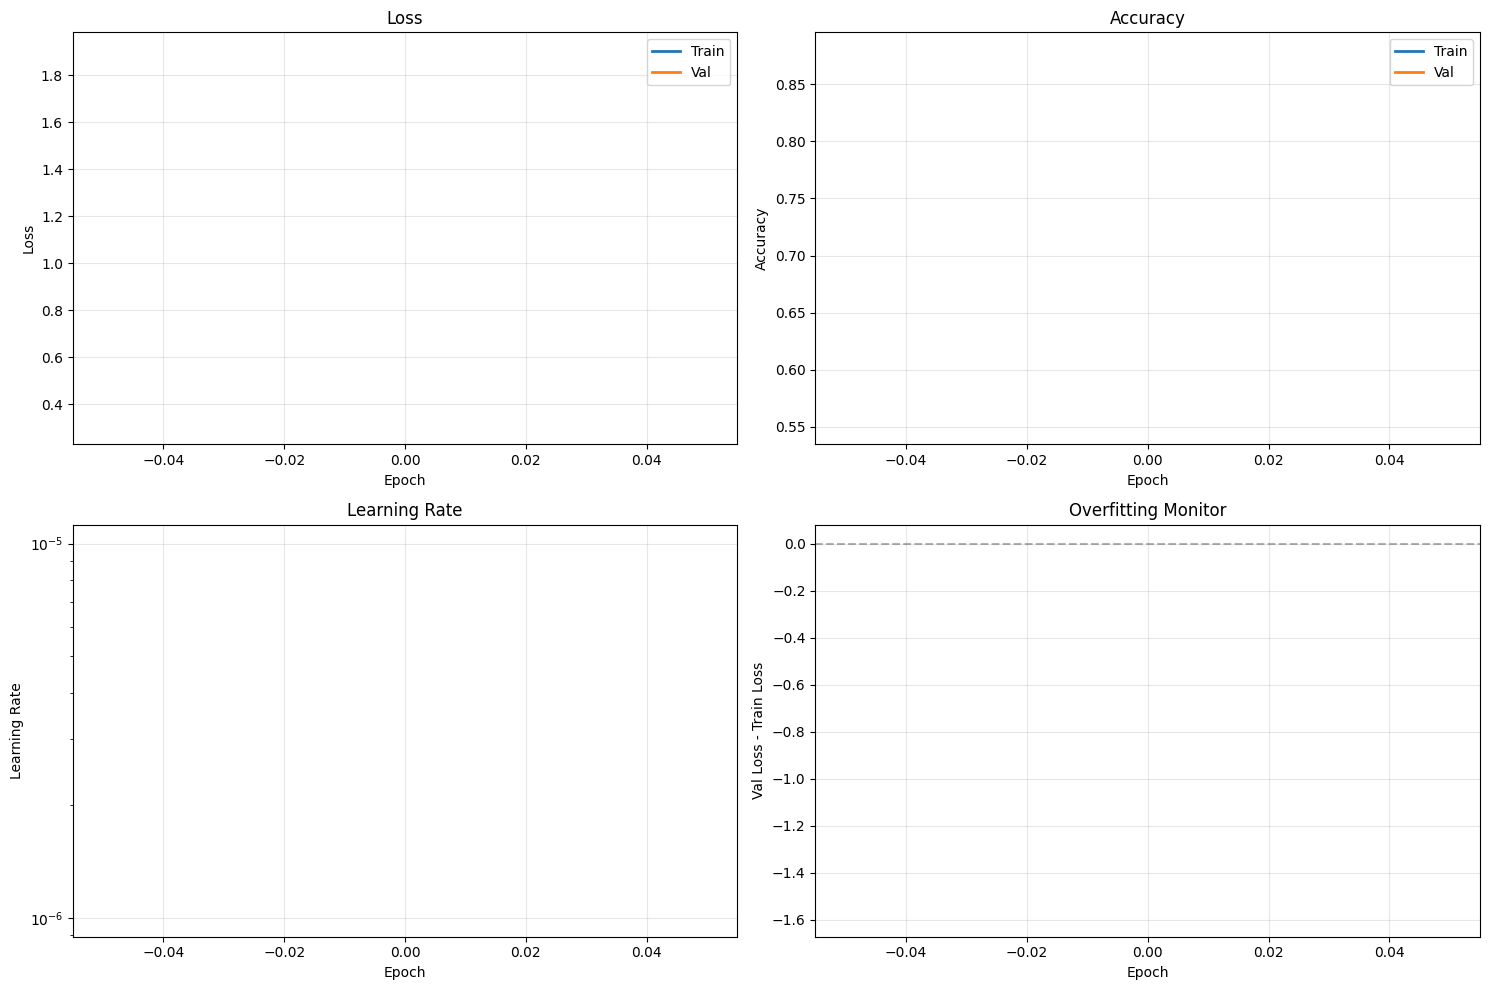

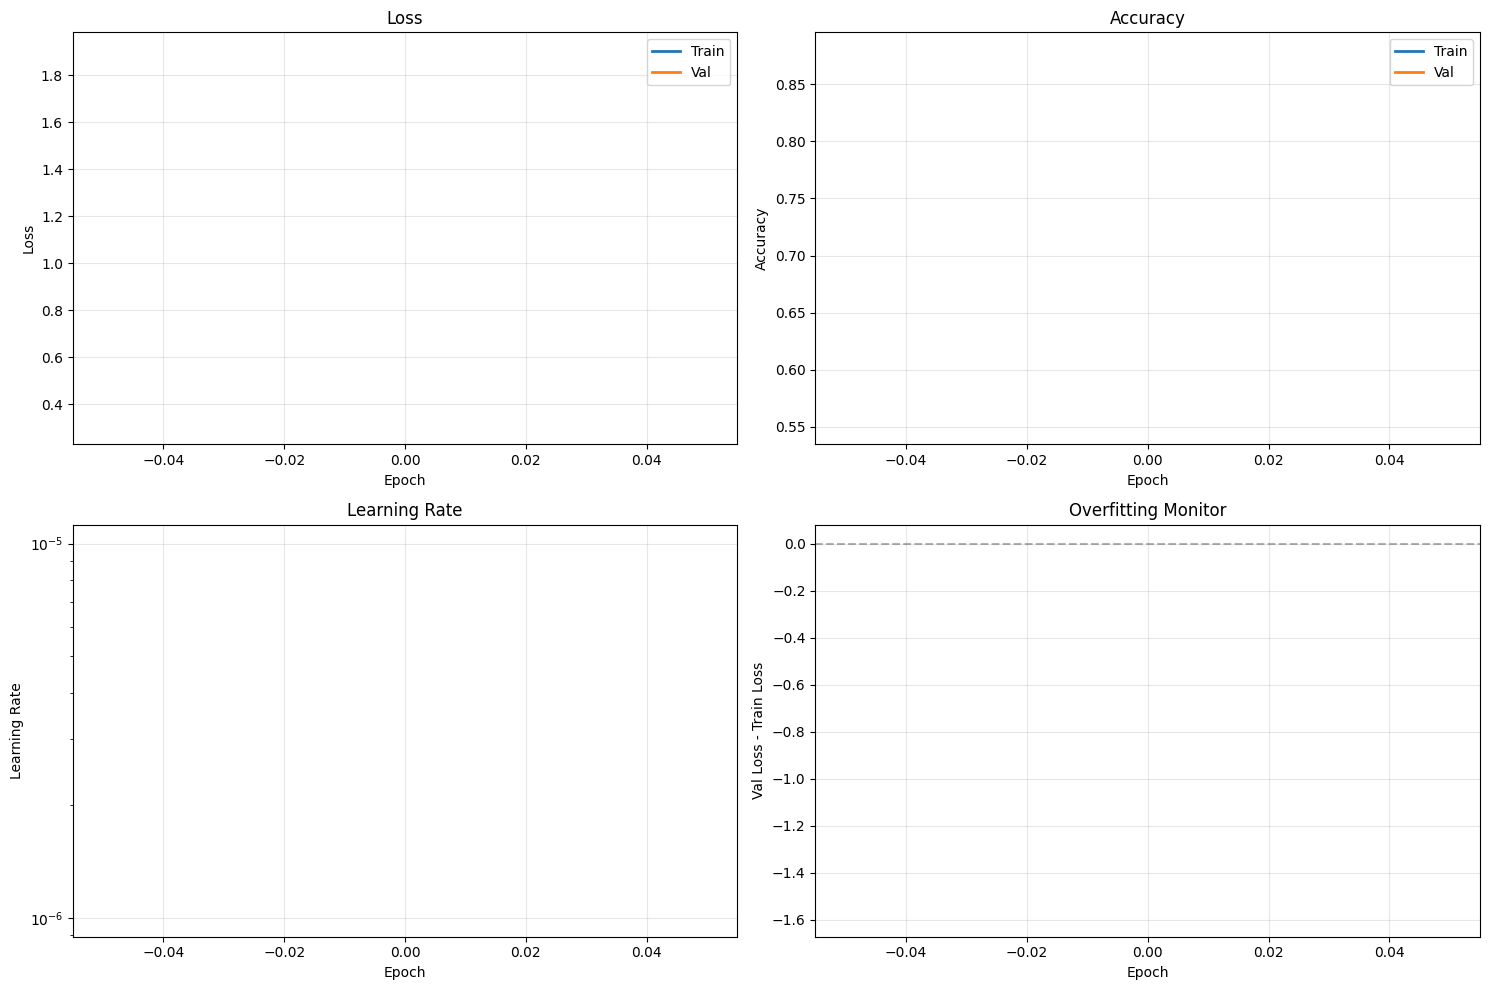

In [15]:
print("\n" + "="*80)
print("SECTION 5: TRAINING")
print("="*80)

# -----------------------------------------------------------------------------
# 5.1: Training Utilities
# -----------------------------------------------------------------------------

class MetricsTracker:
    """Track training metrics"""
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.learning_rates = []
    
    def update(self, train_loss, val_loss, train_acc, val_acc, lr):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_accs.append(train_acc)
        self.val_accs.append(val_acc)
        self.learning_rates.append(lr)
    
    def plot_metrics(self, save_path=None):
        """Plot training curves"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss
        axes[0, 0].plot(self.train_losses, label='Train', linewidth=2)
        axes[0, 0].plot(self.val_losses, label='Val', linewidth=2)
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Accuracy
        axes[0, 1].plot(self.train_accs, label='Train', linewidth=2)
        axes[0, 1].plot(self.val_accs, label='Val', linewidth=2)
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].set_title('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Learning rate
        axes[1, 0].plot(self.learning_rates, linewidth=2, color='orange')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_title('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Overfitting monitor
        loss_diff = np.array(self.val_losses) - np.array(self.train_losses)
        axes[1, 1].plot(loss_diff, linewidth=2, color='red')
        axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Val Loss - Train Loss')
        axes[1, 1].set_title('Overfitting Monitor')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Training curves saved to {save_path}")
        
        plt.show()
        return fig

# -----------------------------------------------------------------------------
# 5.2: Training Functions
# -----------------------------------------------------------------------------

def unfreeze_vit_layers(model, epoch):
    """Gradually unfreeze ViT layers"""
    if epoch < Config.UNFREEZE_EPOCH:
        return
    
    total_layers = 12
    layers_to_unfreeze = min(
        total_layers,
        int((epoch - Config.UNFREEZE_EPOCH) / 2) + 3
    )
    
    for name, param in model.vit.named_parameters():
        if 'encoder.layer' in name:
            layer_num = int(name.split('.')[2])
            if layer_num >= (total_layers - layers_to_unfreeze):
                param.requires_grad = True

def train_epoch(model, train_loader, criterion, optimizer, scaler, device):
    """Train for one epoch"""
    model.train()
    
    total_loss = 0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(train_loader, desc='Training')
    for batch in pbar:
        images = batch['image'].to(device)
        tabular = batch['tabular'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        if Config.USE_AMP and device == 'cuda':
            with torch.cuda.amp.autocast():
                outputs = model(images, tabular)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images, tabular)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Track metrics
        total_loss += loss.item()
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy

def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for batch in pbar:
            images = batch['image'].to(device)
            tabular = batch['tabular'].to(device)
            labels = batch['label'].to(device)
            
            if Config.USE_AMP and device == 'cuda':
                with torch.cuda.amp.autocast():
                    outputs = model(images, tabular)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images, tabular)
                loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy

# -----------------------------------------------------------------------------
# 5.3: Main Training Loop
# -----------------------------------------------------------------------------

print("\n" + "-"*80)
print("Starting training...")
print("-"*80)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with different learning rates
vit_params = []
other_params = []

for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    if 'vit' in name:
        vit_params.append(param)
    else:
        other_params.append(param)

optimizer = optim.AdamW([
    {'params': vit_params, 'lr': Config.LEARNING_RATE * 0.1},
    {'params': other_params, 'lr': Config.LEARNING_RATE}
], weight_decay=Config.WEIGHT_DECAY)

# Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_MAX, eta_min=1e-6)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler() if Config.USE_AMP else None

# Metrics tracker
metrics_tracker = MetricsTracker()

# Training state
best_val_acc = 0.0
patience_counter = 0

print(f"\nTraining Configuration:")
print(f"  Epochs: {Config.NUM_EPOCHS}")
print(f"  Learning Rate: {Config.LEARNING_RATE}")
print(f"  Device: {Config.DEVICE}")
print(f"  Mixed Precision: {Config.USE_AMP}")
print(f"  Early Stopping Patience: {Config.PATIENCE}")
print()

# Training loop
for epoch in range(1, Config.NUM_EPOCHS + 1):
    epoch_start = time.time()
    
    # Unfreeze ViT layers gradually
    unfreeze_vit_layers(model, epoch)
    
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, scaler, Config.DEVICE
    )
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, Config.DEVICE)
    
    # Update scheduler
    scheduler.step()
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    # Update metrics
    metrics_tracker.update(train_loss, val_loss, train_acc, val_acc, current_lr)
    
    # Print epoch summary
    epoch_time = time.time() - epoch_start
    print(f"\nEpoch {epoch}/{Config.NUM_EPOCHS} ({epoch_time:.2f}s)")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"  LR: {current_lr:.2e}")
    
    # Save best model
    if val_acc > best_val_acc + Config.MIN_DELTA:
        print(f"  ✓ New best validation accuracy: {val_acc:.4f}")
        best_val_acc = val_acc
        patience_counter = 0
        
        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'best_val_acc': best_val_acc
        }
        torch.save(checkpoint, os.path.join(Config.SAVE_DIR, 'best_model.pth'))
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= Config.PATIENCE:
        print(f"\n✓ Early stopping triggered after {epoch} epochs")
        break

print("\n" + "="*80)
print("✓ TRAINING COMPLETE!")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print("="*80)

# Plot training curves
metrics_tracker.plot_metrics(
    save_path=os.path.join(Config.SAVE_DIR, 'training_curves.png')
)

# SECTION 6: EVALUATION


SECTION 6: FINAL EVALUATION

Loading best model...
✓ Loaded best model from epoch 1
  Validation Accuracy: 0.8791

--------------------------------------------------------------------------------
Evaluating on test set...
--------------------------------------------------------------------------------


Testing: 100%|██████████| 77/77 [00:14<00:00,  5.38it/s]



Test Set Results:
  Accuracy:  0.8832
  Precision: 0.8916
  Recall:    0.8832
  F1-Score:  0.8810

Per-Class Metrics:
                                  precision    recall  f1-score   support

                          a_Good       0.74      0.99      0.85       308
                      b_Moderate       0.86      0.66      0.75       315
c_Unhealthy_for_Sensitive_Groups       0.94      0.77      0.85       573
                     d_Unhealthy       0.83      0.92      0.87       524
                e_Very_Unhealthy       0.98      0.99      0.98       439
                        f_Severe       0.99      1.00      0.99       289

                        accuracy                           0.88      2448
                       macro avg       0.89      0.89      0.88      2448
                    weighted avg       0.89      0.88      0.88      2448


Confusion matrix saved to /kaggle/working/checkpoints/confusion_matrix.png


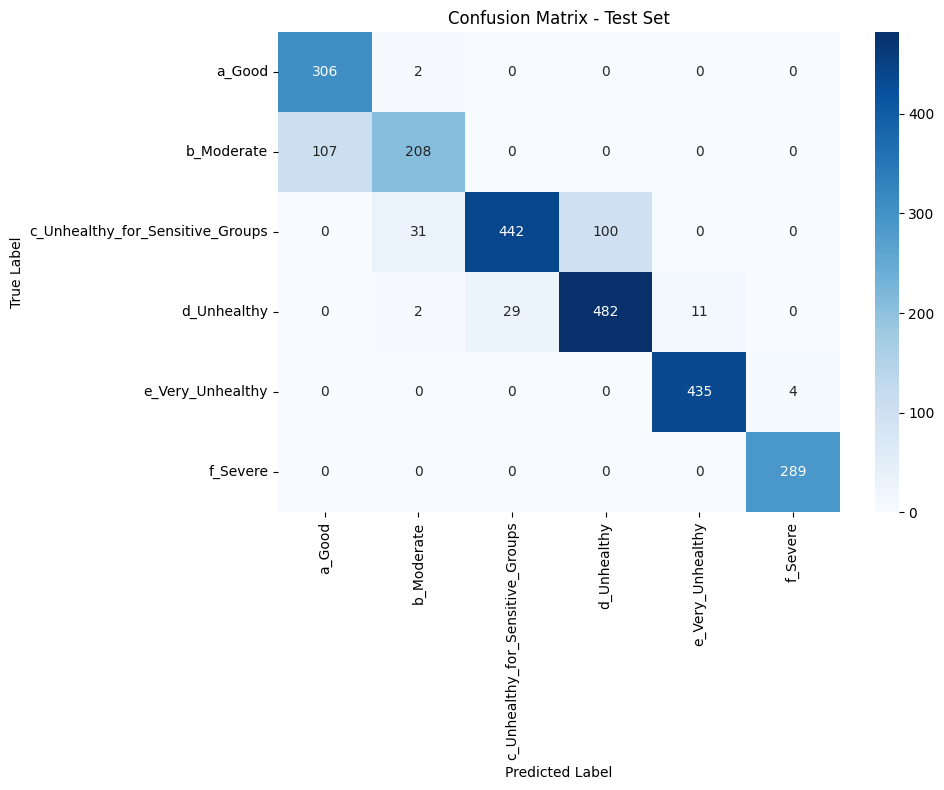


✓ Results saved to /kaggle/working/checkpoints/final_results.json

✓ EVALUATION COMPLETE!


In [16]:
print("\n" + "="*80)
print("SECTION 6: FINAL EVALUATION")
print("="*80)

# Load best model
print("\nLoading best model...")
checkpoint_path = os.path.join(Config.SAVE_DIR, 'best_model.pth')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Loaded best model from epoch {checkpoint['epoch']}")
    print(f"  Validation Accuracy: {checkpoint['val_acc']:.4f}")

# Evaluate on test set
print("\n" + "-"*80)
print("Evaluating on test set...")
print("-"*80)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    pbar = tqdm(test_loader, desc='Testing')
    for batch in pbar:
        images = batch['image'].to(Config.DEVICE)
        tabular = batch['tabular'].to(Config.DEVICE)
        labels = batch['label'].to(Config.DEVICE)
        
        outputs = model(images, tabular)
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted'
)

print(f"\nTest Set Results:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

# Classification report
print(f"\nPer-Class Metrics:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(os.path.join(Config.SAVE_DIR, 'confusion_matrix.png'), dpi=300)
print(f"\nConfusion matrix saved to {Config.SAVE_DIR}/confusion_matrix.png")
plt.show()

# Save results
results = {
    'test_accuracy': float(accuracy),
    'test_precision': float(precision),
    'test_recall': float(recall),
    'test_f1': float(f1),
    'best_val_accuracy': float(best_val_acc),
    'num_classes': int(num_classes),
    'class_names': class_names.tolist(),
    'confusion_matrix': cm.tolist()
}

with open(os.path.join(Config.SAVE_DIR, 'final_results.json'), 'w') as f:
    json.dump(results, f, indent=4)

print(f"\n✓ Results saved to {Config.SAVE_DIR}/final_results.json")

print("\n" + "="*80)
print("✓ EVALUATION COMPLETE!")
print("="*80)

# SECTION 7: INFERENCE FUNCTION


In [17]:
def predict_single_sample(image_path, tabular_dict):
    """
    Make prediction on a single sample
    
    Args:
        image_path: Path to image
        tabular_dict: Dictionary with keys: Year, Month, Day, Hour, 
                      AQI, PM2.5, PM10, O3, CO, SO2, NO2
    
    Returns:
        Dictionary with prediction results
    """
    model.eval()
    
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    transform = get_val_transforms()
    augmented = transform(image=image)
    image_tensor = augmented['image'].unsqueeze(0).to(Config.DEVICE)
    
    # Preprocess tabular data
    df = pd.DataFrame([tabular_dict])
    scaled_tabular, _, _ = tabular_preprocessor.transform(df)
    tabular_tensor = torch.FloatTensor(scaled_tabular).to(Config.DEVICE)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor, tabular_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        pred_class = outputs.argmax(dim=1).item()
        confidence = probabilities[0, pred_class].item()
    
    # Get all probabilities
    all_probs = {
        class_names[i]: probabilities[0, i].item()
        for i in range(len(class_names))
    }
    
    return {
        'predicted_class': class_names[pred_class],
        'confidence': confidence,
        'all_probabilities': all_probs
    }

print("\n" + "="*80)
print("✓ PIPELINE COMPLETE!")
print("="*80)
print(f"\nAll outputs saved to: {Config.SAVE_DIR}")
print("  - best_model.pth: Best model checkpoint")
print("  - training_curves.png: Training visualization")
print("  - confusion_matrix.png: Test set confusion matrix")
print("  - final_results.json: Complete metrics")
print("\nUse predict_single_sample() function for inference on new data!")
print("="*80)


✓ PIPELINE COMPLETE!

All outputs saved to: /kaggle/working/checkpoints
  - best_model.pth: Best model checkpoint
  - training_curves.png: Training visualization
  - confusion_matrix.png: Test set confusion matrix
  - final_results.json: Complete metrics

Use predict_single_sample() function for inference on new data!


In [18]:
import torch
import os

# Define the path
save_path = os.path.join("/kaggle/working/", 'best.pth')

# Save only the weights
torch.save(model.state_dict(), save_path)

print(f"✓ Model weights saved to {save_path}")

✓ Model weights saved to /kaggle/working/best.pth


In [19]:
# Constants needed for instantiation
NUM_CLASSES = len(class_names) # Assuming class_names is already defined
NUM_FEATURES = tabular_data.shape[1] 

# 1. Instantiate the architecture
model = AirPollutionMultimodalModel(
    num_classes=NUM_CLASSES,
    num_tabular_features=NUM_FEATURES,
    vit_model_name=Config.VIT_MODEL,
    pretrained=False # Set to False since we are loading our own weights
)

# 2. Load the .pth file
checkpoint_path = '/kaggle/input/air-polution/best_base.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Check if the checkpoint is a full dictionary or just the state_dict
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
        
    model.to(device)
    model.eval()
    print(f"✓ Model loaded successfully from {checkpoint_path}")
else:
    print(f"× Error: Checkpoint not found at {checkpoint_path}")

Loading Vision Transformer: google/vit-base-patch16-224
✓ Model loaded successfully from /kaggle/input/air-polution/best_base.pth


In [20]:
def generate_vit_gradcam(model, image_tensor, tab_tensor):
    """Generates Grad-CAM for the Vision Transformer branch"""
    model.zero_grad()
    
    # Hook into the last attention block's normalization layer
    activations = []
    def hook_fn(module, input, output):
        activations.append(output)
    
    target_layer = model.vit.encoder.layer[-1].layernorm_before
    handle = target_layer.register_forward_hook(hook_fn)
    
    # Forward Pass
    output = model(image_tensor, tab_tensor)
    idx = output.argmax(dim=1).item()
    
    # Backward Pass
    output[0, idx].backward()
    
    # Get activations and calculate mean attention
    # ViT output: [Batch, Tokens, HiddenDim] -> [1, 197, 768]
    act = activations[0].detach().cpu().squeeze(0) # [197, 768]
    
    # Simple Attention Map: average across the feature dimension
    cam = torch.mean(act, dim=-1) # [197]
    
    # Remove CLS token (first token) and reshape to 14x14 grid
    cam = cam[1:].reshape(14, 14).numpy()
    
    # Resize to original image size
    cam = cv2.resize(cam, (Config.IMG_SIZE, Config.IMG_SIZE))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    
    handle.remove()
    return cam, idx

def visualize_tabular_attention(model, tab_tensor, feature_names):
    """Extracts importance weights from the Gated Fusion layer"""
    with torch.no_grad():
        # Get processed tabular features
        tab_feats = model.tabular_mlp(tab_tensor)
        tab_proj = model.fusion.tabular_projection(tab_feats)
        
        # Access the learnable gate (Sigmoid output)
        gate_weights = model.fusion.gate_tabular(tab_proj)
        importance = gate_weights.squeeze().cpu().numpy()
        
    # We take the mean importance if the gate is a vector
    # In your fusion, gate is (fusion_dim), so we average or map back
    # Since we can't map 256 dims back to 14 perfectly, we show the MLP output importance
    return importance[:len(feature_names)]

def plot_multimodal_explanation(idx, test_dataset, model, feature_names):
    """Generates a combined visualization for a specific test sample"""
    sample = test_dataset[idx]
    img_tensor = sample['image'].unsqueeze(0).to(Config.DEVICE)
    tab_tensor = sample['tabular'].unsqueeze(0).to(Config.DEVICE)
    label = sample['label'].item()
    
    # Run Grad-CAM
    cam_mask, pred_idx = generate_vit_gradcam(model, img_tensor, tab_tensor)
    
    # Run Tabular Importance
    tab_importance = visualize_tabular_attention(model, tab_tensor, feature_names)
    
    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # 1. Original Image
    inv_normalize = A.Normalize(mean=[-m/s for m,s in zip(Config.IMAGENET_MEAN, Config.IMAGENET_STD)], 
                                std=[1/s for s in Config.IMAGENET_STD], max_pixel_value=1.0)
    img_show = inv_normalize(image=sample['image'].permute(1,2,0).cpu().numpy())['image']
    img_show = np.clip(img_show, 0, 1)
    
    axes[0].imshow(img_show)
    axes[0].set_title(f"True: {class_names[label]}\nPred: {class_names[pred_idx]}")
    axes[0].axis('off')
    
    # 2. Grad-CAM Overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    overlay = cv2.addWeighted(img_show, 0.6, heatmap.astype(np.float32), 0.4, 0)
    
    axes[1].imshow(overlay)
    axes[1].set_title("ViT Attention (Spatial Focus)")
    axes[1].axis('off')
    
    # 3. Tabular Bar Chart
    axes[2].barh(feature_names, tab_importance, color='salmon')
    axes[2].set_title("Feature Importance (Gated Fusion)")
    axes[2].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

Generating Multimodal XAI for 5 samples...

--- Visualizing Test Sample Index: 5 (Sample 1/5) ---


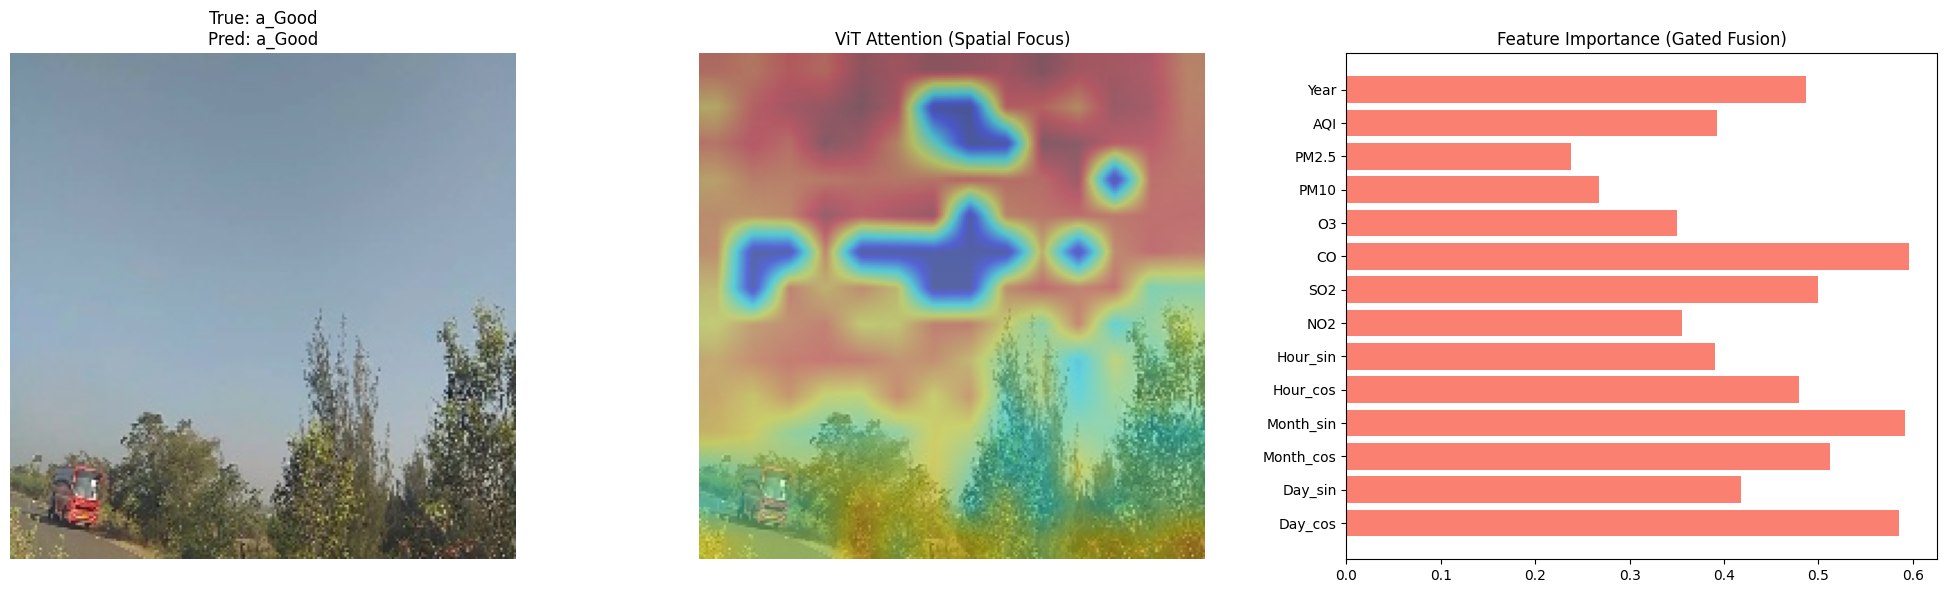


--- Visualizing Test Sample Index: 12 (Sample 2/5) ---


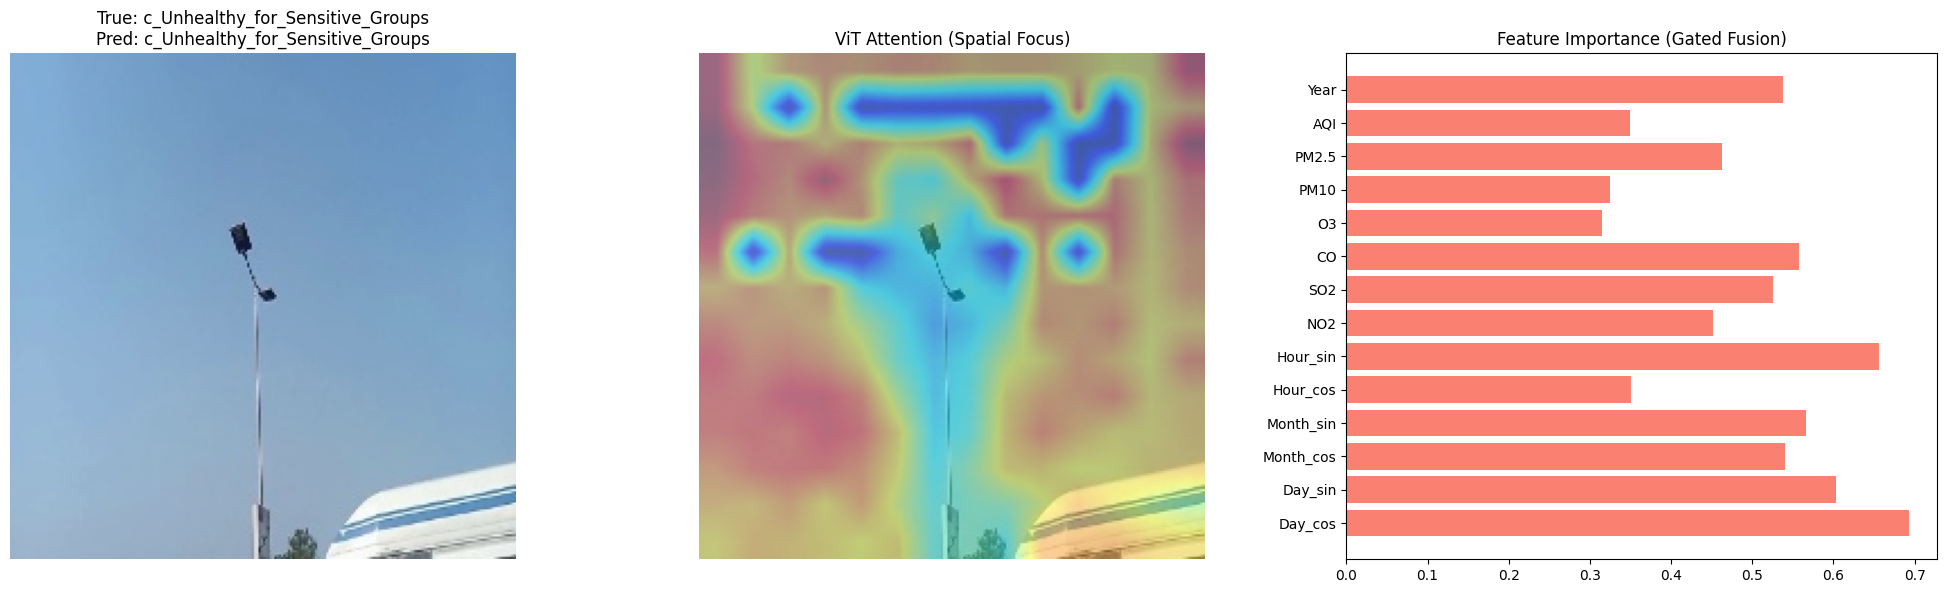


--- Visualizing Test Sample Index: 25 (Sample 3/5) ---


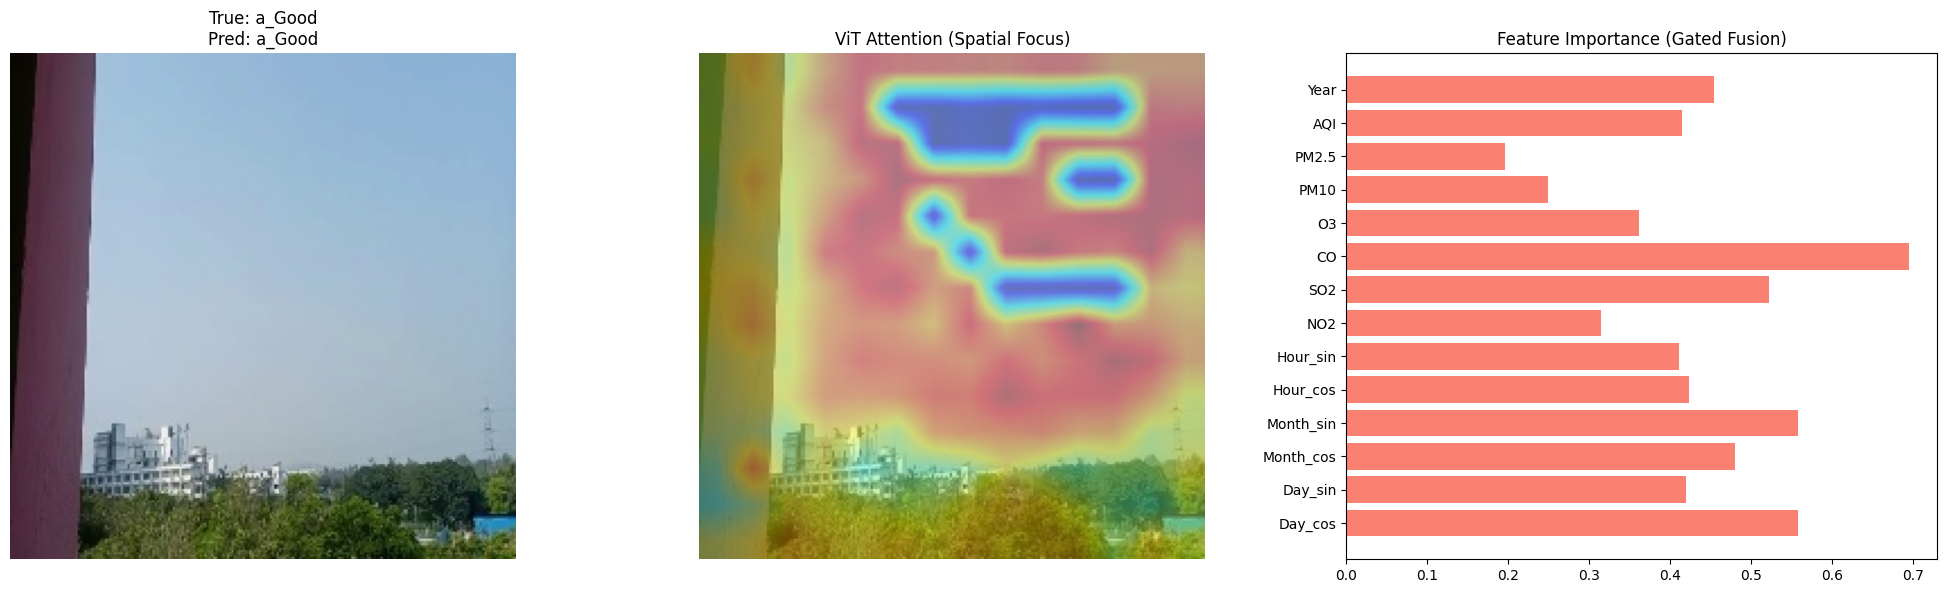


--- Visualizing Test Sample Index: 42 (Sample 4/5) ---


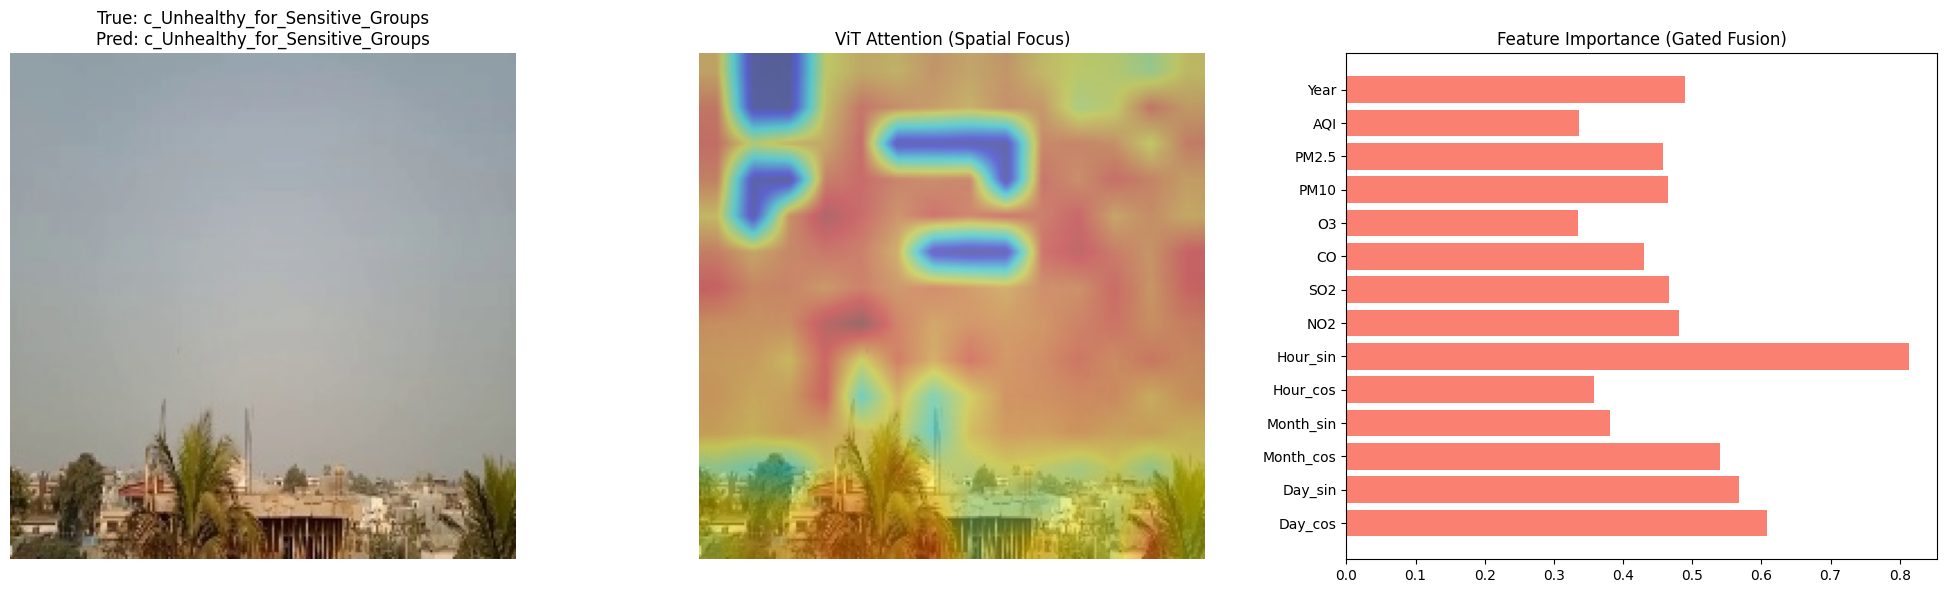


--- Visualizing Test Sample Index: 58 (Sample 5/5) ---


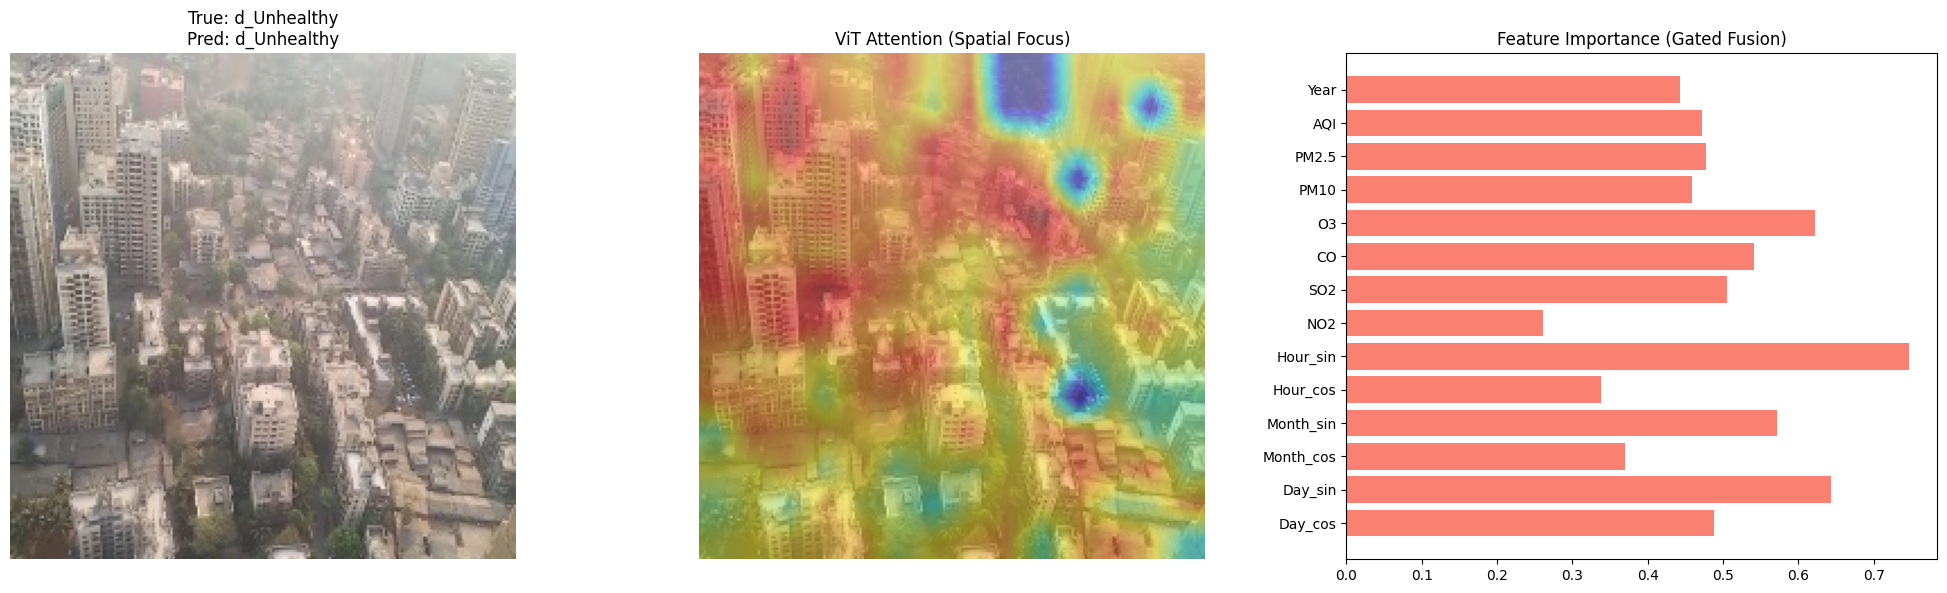

In [21]:
# Select 5 specific indices to visualize
# You can change these to explore different cases (e.g., specific classes)
sample_indices = [5, 12, 25, 42, 58] 

print(f"Generating Multimodal XAI for {len(sample_indices)} samples...")

for i, idx in enumerate(sample_indices):
    print(f"\n--- Visualizing Test Sample Index: {idx} (Sample {i+1}/5) ---")
    plot_multimodal_explanation(
        idx=idx, 
        test_dataset=test_dataset, 
        model=model, 
        feature_names=tabular_preprocessor.feature_names
    )

# AUC Curve

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# 1. Collect all probabilities and true labels
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(Config.DEVICE)
        tabular = batch['tabular'].to(Config.DEVICE)
        labels = batch['label'].to(Config.DEVICE)
        
        outputs = model(images, tabular)
        probs = torch.softmax(outputs, dim=1) # Get probabilities
        
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# 2. Binarize labels for multiclass plotting
# This converts labels (0, 1, 2...) into [1,0,0], [0,1,0] etc.
y_test_bin = label_binarize(all_labels, classes=range(num_classes))

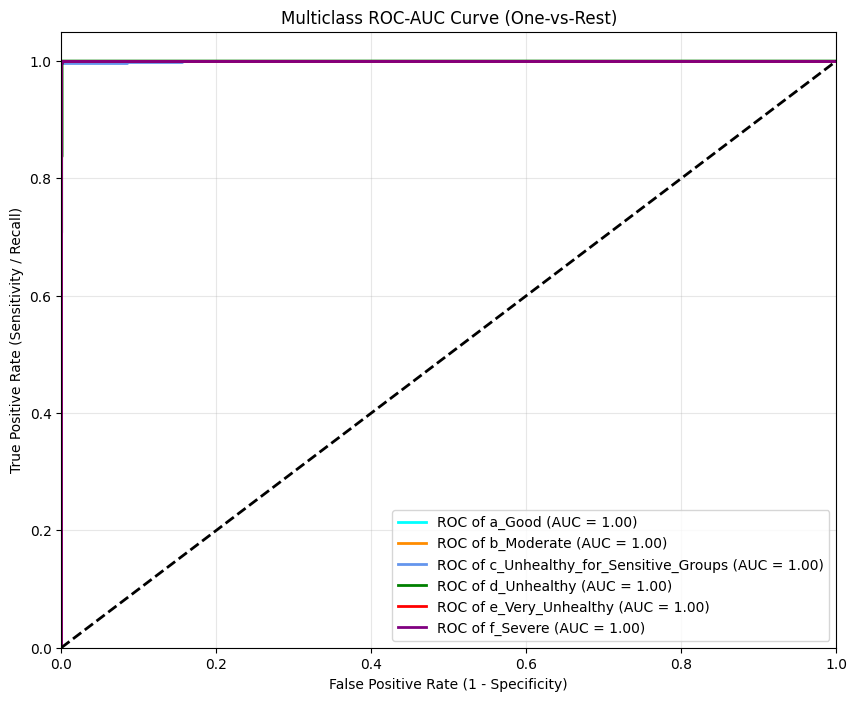

✓ Average AUC Score: 0.9999


In [23]:
# 3. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Plotting
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])

for i, color in zip(range(num_classes), colors):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=2,
        label=f'ROC of {class_names[i]} (AUC = {roc_auc[i]:.2f})'
    )

# Plot the "Random Guess" diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity / Recall)')
plt.title('Multiclass ROC-AUC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig(os.path.join(Config.SAVE_DIR, 'auc_roc_curve.png'), dpi=300)
plt.show()

print(f"✓ Average AUC Score: {np.mean(list(roc_auc.values())):.4f}")

# Show single Model accuracy

In [24]:
class ViTImageClassifier(nn.Module):
    def __init__(self, num_classes, vit_model_name=Config.VIT_MODEL, dropout=0.3):
        super(ViTImageClassifier, self).__init__()
        # Load the same ViT model
        self.vit = ViTModel.from_pretrained(vit_model_name)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        
        # Initial Freeze (same logic as your multimodal code)
        for name, param in self.vit.named_parameters():
            if 'encoder.layer' in name:
                layer_num = int(name.split('.')[2])
                if layer_num < 9: 
                    param.requires_grad = False

    def forward(self, image, tabular=None): # Tabular is ignored to keep DataLoader compatibility
        outputs = self.vit(pixel_values=image)
        # Use the CLS token for classification
        cls_token = outputs.last_hidden_state[:, 0]
        return self.classifier(cls_token)

# Instantiate
model_img = ViTImageClassifier(num_classes=num_classes).to(Config.DEVICE)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
def train_image_only(model, train_loader, val_loader, num_epochs=30):
    criterion = nn.CrossEntropyLoss()
    
    # Differential Learning Rates (Lower for ViT, Higher for Head)
    optimizer = optim.AdamW([
        {'params': model.vit.parameters(), 'lr': Config.LEARNING_RATE * 0.1},
        {'params': model.classifier.parameters(), 'lr': Config.LEARNING_RATE}
    ], weight_decay=Config.WEIGHT_DECAY)

    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.cuda.amp.GradScaler() if Config.USE_AMP else None
    
    best_acc = 0.0
    
    for epoch in range(1, num_epochs + 1):
        # 1. Gradual Unfreezing
        unfreeze_vit_layers(model, epoch) # Reuse your existing function
        
        # 2. Training Phase
        model.train()
        train_loss, correct = 0, 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
            images = batch['image'].to(Config.DEVICE)
            labels = batch['label'].to(Config.DEVICE)
            
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=Config.USE_AMP):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
        
        # 3. Validation Phase
        val_loss, val_acc = validate_simple(model, val_loader, criterion)
        scheduler.step()
        
        print(f"Epoch {epoch}: Train Acc: {correct/len(train_dataset):.4f} | Val Acc: {val_acc:.4f}")
        
        # Save Best
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_image_only.pth')
            print("✓ Saved Best Image Model")

def validate_simple(model, loader, criterion):
    model.eval()
    loss, correct = 0, 0
    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(Config.DEVICE)
            labels = batch['label'].to(Config.DEVICE)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            correct += (outputs.argmax(1) == labels).sum().item()
    return loss/len(loader), correct/len(val_dataset)

# Start training
train_image_only(model_img, train_loader, val_loader)

Epoch 1 [Train]: 100%|██████████| 268/268 [01:54<00:00,  2.33it/s]


Epoch 1: Train Acc: 0.5521 | Val Acc: 0.7328
✓ Saved Best Image Model


Epoch 2 [Train]: 100%|██████████| 268/268 [01:54<00:00,  2.33it/s]


Epoch 2: Train Acc: 0.7387 | Val Acc: 0.8415
✓ Saved Best Image Model


Epoch 3 [Train]: 100%|██████████| 268/268 [01:54<00:00,  2.33it/s]


Epoch 3: Train Acc: 0.8015 | Val Acc: 0.8750
✓ Saved Best Image Model


Epoch 4 [Train]: 100%|██████████| 268/268 [01:54<00:00,  2.33it/s]


Epoch 4: Train Acc: 0.8486 | Val Acc: 0.9216
✓ Saved Best Image Model


Epoch 5 [Train]: 100%|██████████| 268/268 [01:54<00:00,  2.33it/s]


Epoch 5: Train Acc: 0.8734 | Val Acc: 0.9387
✓ Saved Best Image Model


Epoch 6 [Train]: 100%|██████████| 268/268 [01:54<00:00,  2.33it/s]


Epoch 6: Train Acc: 0.8992 | Val Acc: 0.9436
✓ Saved Best Image Model


Epoch 7 [Train]: 100%|██████████| 268/268 [01:54<00:00,  2.33it/s]


Epoch 7: Train Acc: 0.9141 | Val Acc: 0.9551
✓ Saved Best Image Model


Epoch 8 [Train]: 100%|██████████| 268/268 [01:54<00:00,  2.33it/s]


Epoch 8: Train Acc: 0.9241 | Val Acc: 0.9600
✓ Saved Best Image Model


Epoch 9 [Train]: 100%|██████████| 268/268 [01:54<00:00,  2.33it/s]


Epoch 9: Train Acc: 0.9303 | Val Acc: 0.9641
✓ Saved Best Image Model


Epoch 10 [Train]: 100%|██████████| 268/268 [01:54<00:00,  2.33it/s]


Epoch 10: Train Acc: 0.9360 | Val Acc: 0.9690
✓ Saved Best Image Model


Epoch 11 [Train]: 100%|██████████| 268/268 [01:54<00:00,  2.33it/s]


Epoch 11: Train Acc: 0.9447 | Val Acc: 0.9673


Epoch 12 [Train]: 100%|██████████| 268/268 [01:58<00:00,  2.26it/s]


Epoch 12: Train Acc: 0.9470 | Val Acc: 0.9788
✓ Saved Best Image Model


Epoch 13 [Train]: 100%|██████████| 268/268 [01:58<00:00,  2.26it/s]


Epoch 13: Train Acc: 0.9532 | Val Acc: 0.9747


Epoch 14 [Train]: 100%|██████████| 268/268 [02:02<00:00,  2.19it/s]


Epoch 14: Train Acc: 0.9526 | Val Acc: 0.9763


Epoch 15 [Train]: 100%|██████████| 268/268 [02:02<00:00,  2.19it/s]


Epoch 15: Train Acc: 0.9589 | Val Acc: 0.9812
✓ Saved Best Image Model


Epoch 16 [Train]: 100%|██████████| 268/268 [02:06<00:00,  2.12it/s]


Epoch 16: Train Acc: 0.9666 | Val Acc: 0.9779


Epoch 17 [Train]: 100%|██████████| 268/268 [02:06<00:00,  2.12it/s]


Epoch 17: Train Acc: 0.9639 | Val Acc: 0.9837
✓ Saved Best Image Model


Epoch 18 [Train]: 100%|██████████| 268/268 [02:10<00:00,  2.06it/s]


Epoch 18: Train Acc: 0.9706 | Val Acc: 0.9861
✓ Saved Best Image Model


Epoch 19 [Train]: 100%|██████████| 268/268 [02:10<00:00,  2.06it/s]


Epoch 19: Train Acc: 0.9702 | Val Acc: 0.9828


Epoch 20 [Train]: 100%|██████████| 268/268 [02:13<00:00,  2.00it/s]


Epoch 20: Train Acc: 0.9726 | Val Acc: 0.9861


Epoch 21 [Train]: 100%|██████████| 268/268 [02:14<00:00,  2.00it/s]


Epoch 21: Train Acc: 0.9751 | Val Acc: 0.9869
✓ Saved Best Image Model


Epoch 22 [Train]: 100%|██████████| 268/268 [02:17<00:00,  1.94it/s]


Epoch 22: Train Acc: 0.9743 | Val Acc: 0.9845


Epoch 23 [Train]: 100%|██████████| 268/268 [02:17<00:00,  1.94it/s]


Epoch 23: Train Acc: 0.9746 | Val Acc: 0.9869


Epoch 24 [Train]: 100%|██████████| 268/268 [02:21<00:00,  1.89it/s]


Epoch 24: Train Acc: 0.9783 | Val Acc: 0.9869


Epoch 25 [Train]: 100%|██████████| 268/268 [02:21<00:00,  1.89it/s]


Epoch 25: Train Acc: 0.9811 | Val Acc: 0.9877
✓ Saved Best Image Model


Epoch 26 [Train]: 100%|██████████| 268/268 [02:25<00:00,  1.84it/s]


Epoch 26: Train Acc: 0.9819 | Val Acc: 0.9877


Epoch 27 [Train]: 100%|██████████| 268/268 [02:25<00:00,  1.84it/s]


Epoch 27: Train Acc: 0.9806 | Val Acc: 0.9877


Epoch 28 [Train]: 100%|██████████| 268/268 [02:29<00:00,  1.80it/s]


Epoch 28: Train Acc: 0.9816 | Val Acc: 0.9877


Epoch 29 [Train]: 100%|██████████| 268/268 [02:29<00:00,  1.80it/s]


Epoch 29: Train Acc: 0.9819 | Val Acc: 0.9886
✓ Saved Best Image Model


Epoch 30 [Train]: 100%|██████████| 268/268 [02:29<00:00,  1.80it/s]


Epoch 30: Train Acc: 0.9818 | Val Acc: 0.9886


Evaluating Image-Only ViT: 100%|██████████| 77/77 [00:14<00:00,  5.32it/s]



Image-Only ViT RESULTS
                                  precision    recall  f1-score   support

                          a_Good       0.99      0.99      0.99       308
                      b_Moderate       0.99      1.00      0.99       315
c_Unhealthy_for_Sensitive_Groups       0.98      0.97      0.98       573
                     d_Unhealthy       0.98      0.99      0.98       524
                e_Very_Unhealthy       0.99      0.98      0.98       439
                        f_Severe       0.98      1.00      0.99       289

                        accuracy                           0.98      2448
                       macro avg       0.99      0.99      0.99      2448
                    weighted avg       0.98      0.98      0.98      2448



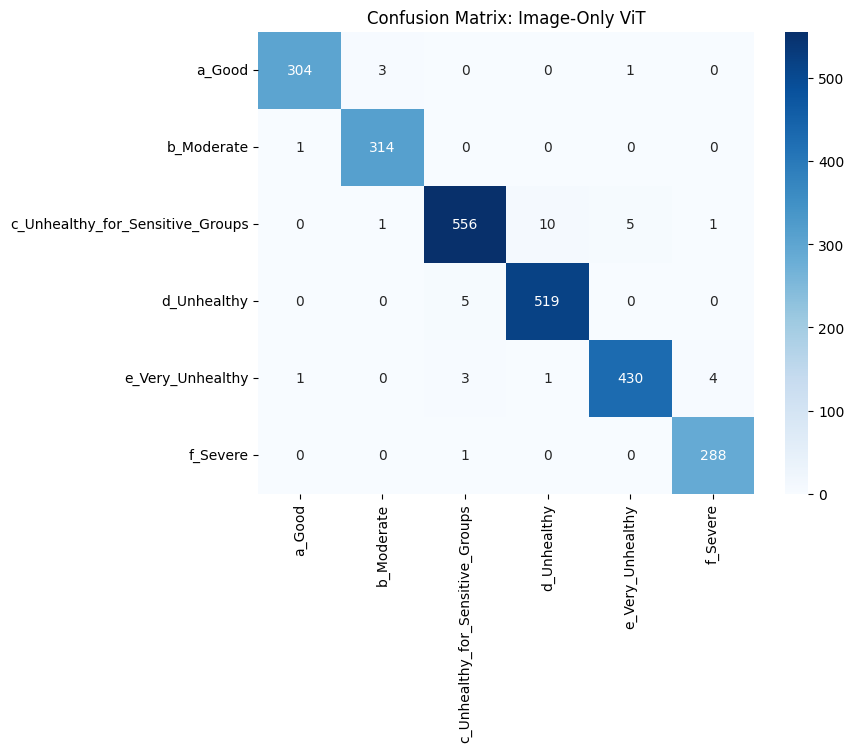

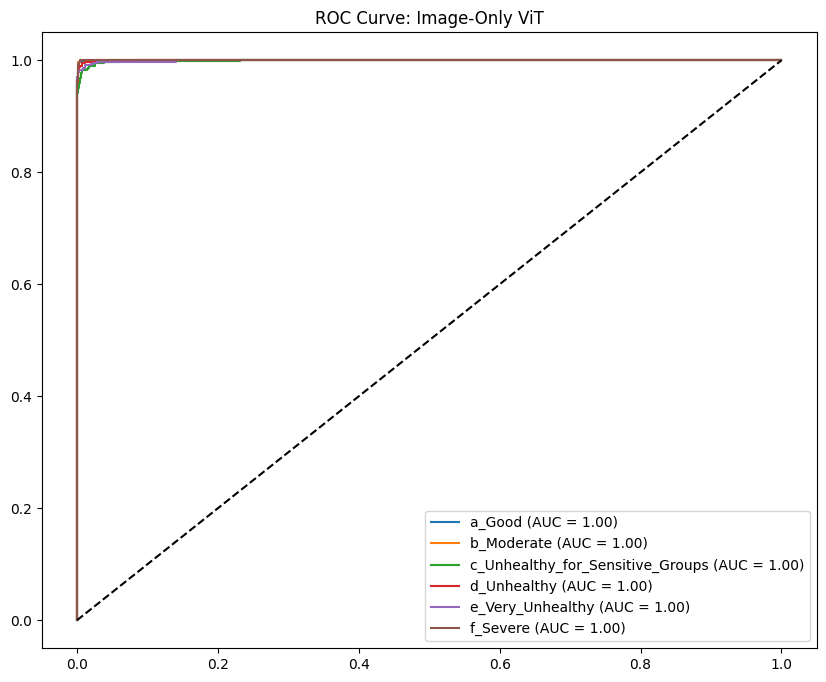

NameError: name 'model_tab' is not defined

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

def evaluate_single_modality(model, dataloader, model_name="Model"):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating {model_name}"):
            images = batch['image'].to(Config.DEVICE)
            tabular = batch['tabular'].to(Config.DEVICE)
            labels = batch['label'].to(Config.DEVICE)
            
            outputs = model(images, tabular)
            probs = F.softmax(outputs, dim=1)
            
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # 1. Metrics & Report
    print(f"\n{'='*30}\n{model_name} RESULTS\n{'='*30}")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # 2. Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

    # 3. AUC Curve
    y_test_bin = label_binarize(all_labels, classes=range(len(class_names)))
    all_probs = np.array(all_probs)
    
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc(fpr, tpr):.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve: {model_name}")
    plt.legend()
    plt.show()

# Usage Examples:
evaluate_single_modality(model_img, test_loader, "Image-Only ViT")
evaluate_single_modality(model_tab, test_loader, "Tabular-Only MLP")

# just tabular 

In [27]:
class TabularOnlyClassifier(nn.Module):
    def __init__(self, num_tabular_features, num_classes, dropout=0.3):
        super(TabularOnlyClassifier, self).__init__()
        
        # Reuse your existing AttentionMLP architecture
        self.tabular_mlp = AttentionMLP(
            input_dim=num_tabular_features,
            hidden_dims=[256, 128],
            output_dim=128,
            dropout=dropout
        )
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, image, tabular):
        # We ignore the image input to keep the DataLoader compatible
        features = self.tabular_mlp(tabular)
        logits = self.classifier(features)
        return logits

# Instantiate
model_tab = TabularOnlyClassifier(
    num_tabular_features=num_tabular_features, 
    num_classes=num_classes
).to(Config.DEVICE)

In [28]:
def train_tabular_only(model, train_loader, val_loader, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    best_tab_acc = 0.0
    metrics = {'train_acc': [], 'val_acc': []}

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss, correct = 0, 0
        
        for batch in train_loader:
            tabular = batch['tabular'].to(Config.DEVICE)
            labels = batch['label'].to(Config.DEVICE)
            
            optimizer.zero_grad()
            outputs = model(None, tabular) # No image needed
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
        
        # Validation
        val_loss, val_acc = validate_tab(model, val_loader, criterion)
        scheduler.step()
        
        metrics['train_acc'].append(correct / len(train_dataset))
        metrics['val_acc'].append(val_acc)
        
        if val_acc > best_tab_acc:
            best_tab_acc = val_acc
            torch.save(model.state_dict(), 'best_tabular_only.pth')

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Acc: {metrics['train_acc'][-1]:.4f} | Val Acc: {val_acc:.4f}")

    print(f"\n✓ Best Tabular Validation Accuracy: {best_tab_acc:.4f}")
    return metrics

def validate_tab(model, loader, criterion):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch in loader:
            tabular = batch['tabular'].to(Config.DEVICE)
            labels = batch['label'].to(Config.DEVICE)
            outputs = model(None, tabular)
            correct += (outputs.argmax(1) == labels).sum().item()
    return 0, correct / len(val_dataset)

# Start training
tab_metrics = train_tabular_only(model_tab, train_loader, val_loader)

Epoch 10: Train Acc: 0.9917 | Val Acc: 1.0000
Epoch 20: Train Acc: 0.9910 | Val Acc: 1.0000
Epoch 30: Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 40: Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 50: Train Acc: 1.0000 | Val Acc: 1.0000

✓ Best Tabular Validation Accuracy: 1.0000


Evaluating Tabular-Only (Attention MLP): 100%|██████████| 77/77 [00:05<00:00, 13.00it/s]



Tabular-Only (Attention MLP) RESULTS
                                  precision    recall  f1-score   support

                          a_Good       1.00      1.00      1.00       308
                      b_Moderate       1.00      1.00      1.00       315
c_Unhealthy_for_Sensitive_Groups       1.00      1.00      1.00       573
                     d_Unhealthy       1.00      1.00      1.00       524
                e_Very_Unhealthy       1.00      1.00      1.00       439
                        f_Severe       1.00      1.00      1.00       289

                        accuracy                           1.00      2448
                       macro avg       1.00      1.00      1.00      2448
                    weighted avg       1.00      1.00      1.00      2448



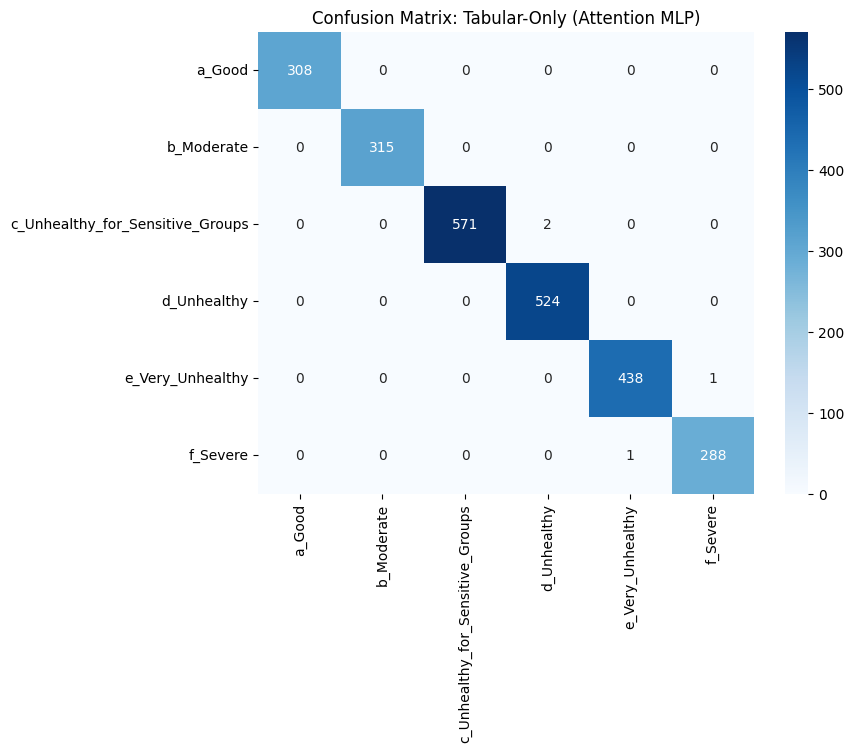

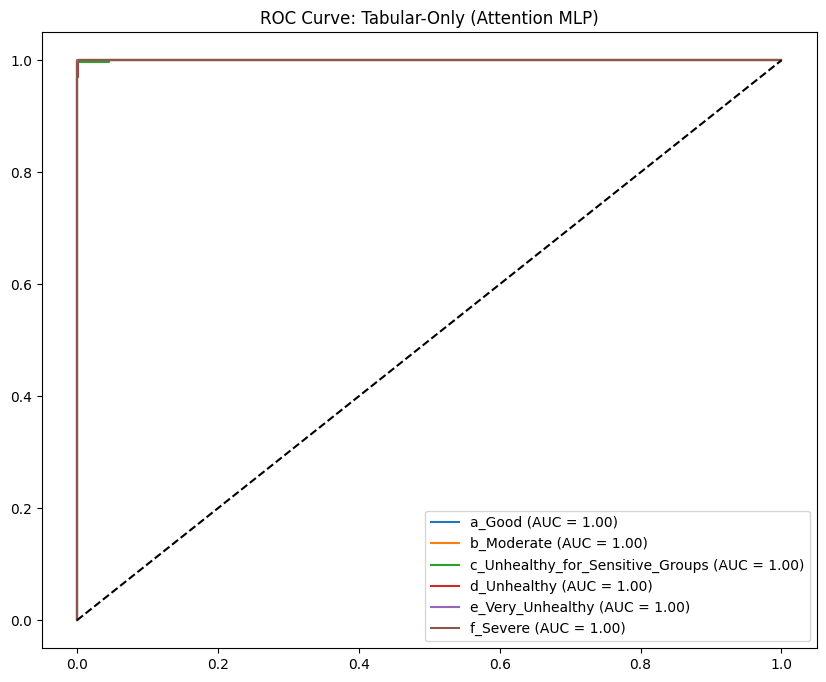

In [29]:
# Evaluate the best version on Test Set
model_tab.load_state_dict(torch.load('best_tabular_only.pth'))
evaluate_single_modality(model_tab, test_loader, "Tabular-Only (Attention MLP)")